# Discovering structure behind data

Let's understand and model the hidden structure behind data with Decision Trees. In this tutorial, we'll explore and inspect how a model can do its decisions on a car evaluation data set. Decision trees work with simple "if" clauses dichotomically chained together, splitting the data flow recursively on those "if"s until they reach a leaf where we can categorize the data. Such data inspection could be used to reverse engineer the behavior of any function. 

Since [decision trees](http://www.r2d3.us/visual-intro-to-machine-learning-part-1/) are good algorithms for discovering the structure hidden behind data, we'll use and model the car evaluation data set, for which the prediction problem is a (deterministic) surjective function. This means that the inputs of the examples in the data set cover all the possibilities, and that for each possible input value, there is only one answer to predict (thus, two examples with the same input values would never have a different expected prediction). On the point of view of Data Science, because of the properties of our dataset, we won't need to use a test set nor to use cross validation. Thus, the error we will obtain below at modelizing our dataset would be equal to the true test error if we had a test set.

The attribute to predict in the data set could have been, for example, created from a programmatic function and we will basically reverse engineer the logic mapping the inputs to the outputs to recreate the function and to be able to explain it visually.


## About the Car Evaluation Data Set

For more information: http://archive.ics.uci.edu/ml/datasets/Car+Evaluation

### Overview

The Car Evaluation Database was derived from a simple hierarchical decision model originally developed for the demonstration of DEX, M. Bohanec, V. Rajkovic: Expert system for decision making. Sistemica 1(1), pp. 145-157, 1990.). The model evaluates cars according to the following concept structure: 

- CAR car acceptability:
  - PRICE overall price:
    - **buying** buying price
    - **maint** price of the maintenance
  - TECH technical characteristics:
    - COMFORT comfort:
      - **doors** number of doors
      - **persons** capacity in terms of persons to carry
      - **lug_boot** the size of luggage boot
    - **safety** estimated safety of the car

Input attributes are printed in lowercase. Besides the target concept (CAR), the model includes three intermediate concepts: PRICE, TECH, COMFORT. Every concept is in the original model related to its lower level descendants by a set of examples. 

The Car Evaluation Database contains examples with the structural information removed, i.e., directly relates CAR to the six input attributes: buying, maint, doors, persons, lug_boot, safety. 

Because of known underlying concept structure, this database may be particularly useful for testing constructive induction and structure discovery methods. 

### Attributes, instances, and Class Distribution

Number of Attributes: 6

Missing Attribute Values: none

| Attribute  | Values |
|------------|--------|
| buying     | v-high, high, med, low |
| maint      | v-high, high, med, low |
| doors      | 2, 3, 4, 5-more |
| persons    | 2, 4, more |
| lug_boot   | small, med, big |
| safety     | low, med, high |

Number of Instances: 1728 (Instances completely cover the attribute space.)

| class | N | N[%] |
|---|---|---|
| unacc | 1210 | 70.023 % |
| acc | 384 | 22.222 % |
| good | 69 | 3.993 % |
| v-good | 65 | 3.762 % |


## We'll now load the car evaluation data set in Python and then train decision trees with Scikit-Learn

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn import tree
import pydot

from io import StringIO
import os

### Define the features and preprocess the car evaluation data set

We'll preprocess the attributes into redundant features, such as using an integer index (linear) to represent a value for an attribute, as well as also using a one-hot encoding for each attribute's possible values as new features. Despite the fact that this is redundant, this will help to make the tree smaller since it has more choice on how to split data on each branch. 

In [2]:
# The integer values for features will take
# a range from 0 to n-1 in the lists of possible values:
input_labels = [
    ["buying", ["vhigh", "high", "med", "low"]],
    ["maint", ["vhigh", "high", "med", "low"]],
    ["doors", ["2", "3", "4", "5more"]],  # Here indexes are not real values
    ["persons", ["2", "4", "more"]],
    ["lug_boot", ["small", "med", "big"]],
    ["safety", ["low", "med", "high"]],
]

class_names = ["unacc", "acc", "good", "vgood"]

# Load data set
data = np.genfromtxt(os.path.join('data', 'car.data'), delimiter=',', dtype="U")
data_inputs = data[:, :-1]
data_outputs = data[:, -1]

def str_data_to_one_hot(data, input_labels):
    """Convert each feature's string to a flattened one-hot array. """
    X_int = LabelEncoder().fit_transform(data.ravel()).reshape(*data.shape)
    X_bin = OneHotEncoder().fit_transform(X_int).toarray()
    
    feature_names = []
    for a in input_labels:
        key = a[0]
        for b in a[1]:
            value = b
            feature_names.append("{}_is_{}".format(key, value))

    return X_bin, feature_names

def str_data_to_linear(data, input_labels):
    """Convert each feature's string to an integer index"""
    X_lin = np.array([[
        input_labels[a][1].index(j) for a, j in enumerate(i)
    ] for i in data])
    
    # Integer feature indexes will range
    # from 0 to n-1 from indexes in the label list:
    feature_names = [i[0] + "_index" for i in input_labels]
    
    return X_lin, feature_names

# Take both one-hot and linear versions of input features: 
X_one_hot, feature_names_one_hot = str_data_to_one_hot(data_inputs, input_labels)
X_linear_int, feature_names_linear_int = str_data_to_linear(data_inputs, input_labels)

# Put that together:
X = np.concatenate([X_one_hot, X_linear_int], axis=-1)
feature_names = feature_names_one_hot + feature_names_linear_int

# Outputs use indexes, this is not one-hot:
integer_y = np.array([class_names.index(i) for i in data_outputs])

print("Data set's shape,")
print("X.shape, integer_y.shape, len(feature_names), len(class_names):")
print(X.shape, integer_y.shape, len(feature_names), len(class_names))


Data set's shape,
X.shape, integer_y.shape, len(feature_names), len(class_names):
(1728, 27) (1728,) 27 4


### Train a simple decision tree to fit the data set:

First, let's define some hyperparameters, such as the depth of the tree.

In [3]:
max_depth = 6
clf = tree.DecisionTreeClassifier(max_depth=max_depth)
clf = clf.fit(X, integer_y)

print("Decision tree trained!")
accuracy = clf.score(X, integer_y)
print("Errors:", 100 - accuracy * 100, "%")
print("Accuracy:", accuracy * 100, "%")

Decision tree trained!
Errors: 6.53935185185 %
Accuracy: 93.4606481481 %


### Plot and save the tree

In [4]:
def plot_first_tree(clf, class_names, tree_name):
    """
    Plot and save our scikit-learn tree.
    """
    graph_save_path = os.path.join(
        "exported_sklearn_trees", 
        "{}".format(tree_name)
    )

    tree.export_graphviz(clf, out_file="{}.dot".format(graph_save_path))
    dotfile = StringIO()
    tree.export_graphviz(
        clf, out_file=dotfile,
        feature_names=feature_names, class_names=class_names,
        filled=True, rotate=True
    )
    pydot.graph_from_dot_data(dotfile.getvalue())[0].write_png("{}.png".format(graph_save_path))

# Plot our simple tree:
plot_first_tree(clf, class_names, tree_name="simple_tree")

Note that [the tree below can also be viewed here online](https://github.com/Vooban/Decision-Trees-For-Knowledge-Discovery/tree/master/exported_sklearn_trees).

![simple tree](exported_sklearn_trees/simple_tree.png)

### Plot the importance of each input features of the simple tree:

Note here that it is the feature importance according to our simple, shallow tree. A fully complex trees would surely include more of the features/attributes, and with different proportions. 

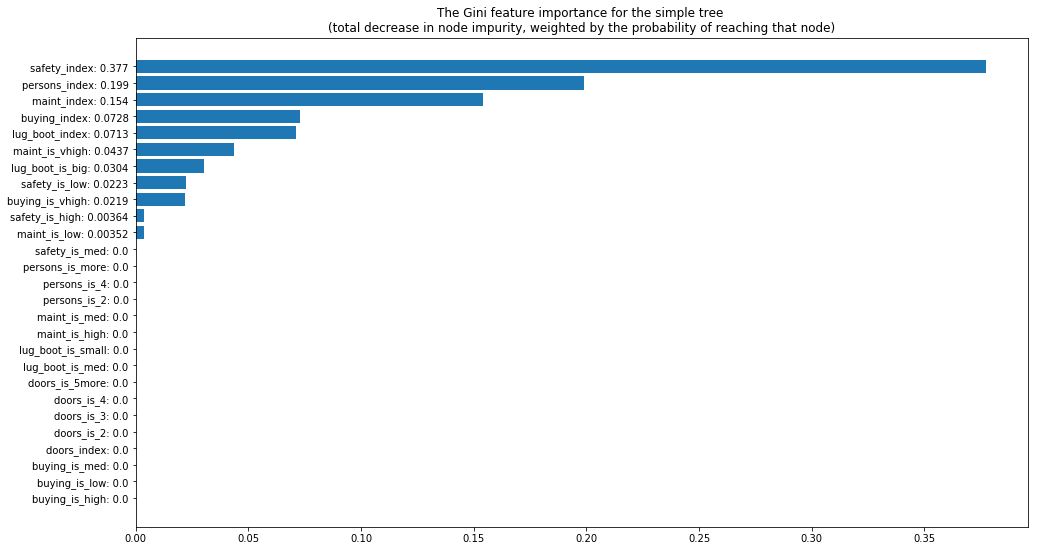

In [5]:
def feature_importance_chart(clf, classifier_name, feature_names):
    sorted_feature_importances, sorted_feature_names = (
        zip(*sorted(zip(clf.feature_importances_, feature_names)))
    )
    plt.figure(figsize=(16, 9))
    plt.barh(range(len(sorted_feature_importances)), sorted_feature_importances)
    plt.yticks(
        range(len(sorted_feature_importances)),
        ["{}: {:.3}".format(a, b) for a, b in zip(sorted_feature_names, sorted_feature_importances)]
    )
    plt.title("The Gini feature importance for the {} \n"
              "(total decrease in node impurity, weighted by the "
              "probability of reaching that node)".format(classifier_name))
    plt.show()

feature_importance_chart(clf, "simple tree", feature_names)

### Let's now generate a fully perfect (complex) tree

<p align="center">
  <a href="http://theinceptionbutton.com/" ><img src="deeper.jpg" /></a>
</p>

Let's [go deeper](http://theinceptionbutton.com/). Let's build a deeper tree. At least, a simple tree like the one above is interesting for having a simplfied view of the true logic behind our data.

In [6]:
max_depth = None  # Full depth
clf = tree.DecisionTreeClassifier(max_depth=max_depth)
clf = clf.fit(X, integer_y)

print("Decision tree trained!")
accuracy = clf.score(X, integer_y)
print("Errors:", 100 - accuracy * 100, "%")
print("Accuracy:", accuracy * 100, "%")

Decision tree trained!
Errors: 0.0 %
Accuracy: 100.0 %


### A plot of the full tree

In [7]:
plot_first_tree(clf, class_names, tree_name="complex_tree")

Note that [the tree below can also be viewed here online](https://github.com/Vooban/Decision-Trees-For-Knowledge-Discovery/tree/master/exported_sklearn_trees). It would also be possible to [extract the tree as true code and create a function](https://stackoverflow.com/questions/20224526/how-to-extract-the-decision-rules-from-scikit-learn-decision-tree).

![complex tree](exported_sklearn_trees/complex_tree.png)

### Finally, the full feature importance:

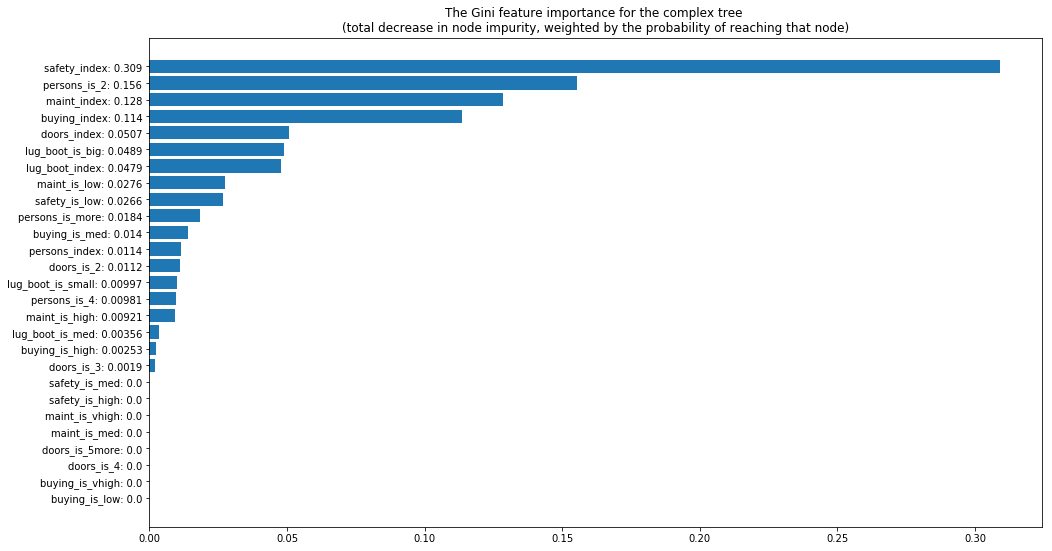

In [8]:
feature_importance_chart(clf, "complex tree", feature_names)


## Conclusion

To sum up, we managed to get good classification results and to be able to explain those results visually and automatically. Note that it would have been possible to solve a regression problem with the same algorithm, such as predicting a price rather than a category.

Such a technique can be useful in reverse engineering an existing system, such as an old one that has been coded in a peculiar programming language and for which the employees who coded it have left. This technique can also be used for data mining, gaining business intelligence, and insights from data.

In the case that your data does not represent a pure function like we have here, such as if for two of your input examples it is possible to have two possible different predictions, then a tree cannot model the data set with 100% accuracy. Hopefully, if you are in that situation where the logic behind the data is not perfect, it is possible to [repeat the experiment by using XGBoost](https://github.com/Vooban/Decision-Trees-For-Knowledge-Discovery/blob/master/Decision-Trees-For-Knowledge-Discovery-With-XGBoost.ipynb), which can help by incrementally training many trees to reduce the error and training them in an optimized fashion. The only disadvantage of that is that those boosted forests would be harder to explain due to the fact that you would have many trees.

In [9]:
# Let's convert this notebook to a README for the GitHub project's title page:
!jupyter nbconvert --to markdown Decision-Trees-For-Knowledge-Discovery-With-Scikit-Learn.ipynb
!mv Decision-Trees-For-Knowledge-Discovery-With-Scikit-Learn.md README.md

[NbConvertApp] Converting notebook Decision-Trees-For-Knowledge-Discovery-With-Scikit-Learn.ipynb to markdown
[NbConvertApp] Support files will be in Decision-Trees-For-Knowledge-Discovery-With-Scikit-Learn_files/
[NbConvertApp] Making directory Decision-Trees-For-Knowledge-Discovery-With-Scikit-Learn_files
[NbConvertApp] Making directory Decision-Trees-For-Knowledge-Discovery-With-Scikit-Learn_files
[NbConvertApp] Writing 12276 bytes to Decision-Trees-For-Knowledge-Discovery-With-Scikit-Learn.md
